In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import dirname, abspath
from skimage.morphology import reconstruction, remove_small_objects, remove_small_holes

In [11]:
image_dir = dirname(dirname(abspath("X"))) + "/data/"

In [5]:
def show_image(image, name='image'):
    cv2.imshow(name,image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(896L, 1017L)


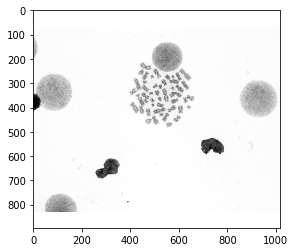

In [10]:
img = cv2.imread(parent_dir + '/data/dapi_raw_obr.BMP', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [12]:
img = cv2.imread(parent_dir + '/data/dapi_raw_obr.BMP', 0)
median = cv2.medianBlur(img, 5)
cv2.imwrite(image_dir + "dapi_median_filtered.BMP", median)


True

In [6]:
gray = cv2.imread(parent_dir + '/data/dapi_raw.BMP', 0)
ret1, th1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite(parent_dir + "/data/dapi_raw_thresholded.BMP", th1)
im2, contours, hierarchy = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
white_image = 255 - np.zeros_like(gray)
image_with_contours = cv2.drawContours(white_image, contours, -1, (0, 255, 0), thickness=1)
cv2.imwrite(image_dir + "dapi_contours.BMP", image_with_contours)

True

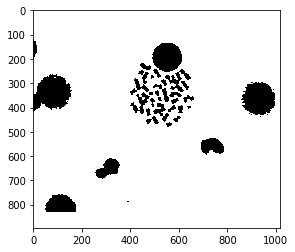

In [10]:
kernel = np.ones((5,5),np.uint8)
reversed_thresh = 255 - th1
closing = cv2.morphologyEx(reversed_thresh, cv2.MORPH_CLOSE, kernel)
closing = 255 - closing
cv2.imwrite(parent_dir + "/data/dapi_threshed_closing.BMP", closing)
plt.imshow(closing, cmap='gray')

(<matplotlib.figure.Figure at 0x54fc4e0>,
 <matplotlib.image.AxesImage at 0x15b7e978>)

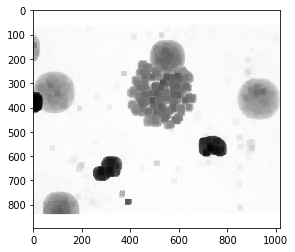

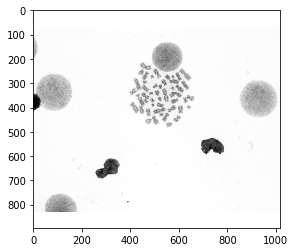

In [12]:
# Opening-by-reconstruction = Erosion + Morphological reconstruction

I = gray.copy()

# Erosion
se = cv2.getStructuringElement(cv2.MORPH_ERODE, (20, 20)) # structure element
Ie = cv2.erode(I, se, iterations=1)

# Morphological reconstruction = iteratively dilation
Iobr = reconstruction(Ie, I, method='dilation')
cv2.imwrite(parent_dir + "/data/dapi_threshed_obr.BMP", Iobr)

plt.figure(), plt.imshow(Ie, cmap='gray')
plt.figure(), plt.imshow(Iobr, cmap='gray')

(<matplotlib.figure.Figure at 0x6ec9e48>,
 <matplotlib.image.AxesImage at 0x151f7eb8>)

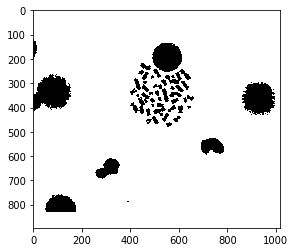

In [17]:
img_obr = cv2.imread(parent_dir + '/data/dapi_raw_obr.BMP', 0)
ret, thresh = cv2.threshold(img_obr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite(parent_dir + "/data/dapi_obr_threshed.BMP", thresh)
plt.figure(), plt.imshow(thresh, cmap='gray')

In [20]:
th1 = cv2.imread(parent_dir + '/data/dapi_obr_threshed.BMP', 0)
im2, contours, hierarchy = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
white_image = 255 - np.zeros_like(gray)
image_with_contours = cv2.drawContours(white_image, contours, contourIdx=-1, color=2, thickness=1)
cv2.imwrite(parent_dir + "/data/dapi_contours.BMP", image_with_contours)

True

In [14]:
gray = cv2.imread(image_dir + "dapi_median_filtered.BMP", 0)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Coutours
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(gray, contours, -1, (0, 255, 0), 3)

num_contour = len(contours)

# Create a mask
mask_contour = np.zeros(image_with_contours.shape)
mask_contour = mask_contour.astype('int')
print("Len contours: ", len(contours));
cnt = 0
for id, contour in enumerate(contours):
    for point in contour:
        # X: point[0][1], Y: point[0][0]
        x = point[0][1]
        y = point[0][0]
        mask_contour[x][y] = id + 1
    cnt += len(contour)

valid = {k: 0 for k in range(1, num_contour + 1)}
in_valid = {k: 0 for k in range(1, num_contour + 1)}
    
def sliding_window(image, stride=32, window_size=(20, 20), num_contour_threshold=3):
    # slide a window across the image
    for y in range(0, image.shape[0], stride):
        for x in range(0, image.shape[1], stride):
            arr_window = mask_contour[x: x + window_size[0], y: y + window_size[1]]
            unique, counts = np.unique(arr_window, return_counts=True)         
            num_con_window = np.count_nonzero(unique)
            if num_con_window > num_contour_threshold:
                for con_id in unique:
                    if con_id == 0: 
                        continue
                    valid[con_id] = valid[con_id] + 1
            else:
                for con_id in unique:
                    if con_id == 0: 
                        continue
                    in_valid[con_id] = in_valid[con_id] + 1


print("Len contours: ", len(contours));
cnt = 0
for id, contour in enumerate(contours):
    for point in contour:
        # X: point[0][1], Y: point[0][0]
        x = point[0][1]
        y = point[0][0]
        mask_contour[x][y] = id + 1
    cnt += len(contour)
    
print(image_with_contours.shape)

sliding_window(image_with_contours, 20, (100, 100))
print(valid)
print(in_valid)
chosen_contours = list()
accept_ratio = 2
new_contours = list()
for i in range(1, num_contour + 1):
    if valid[i] * accept_ratio < in_valid[i]:
        new_contours.append(contours[i - 1])
        
        
white_image = 255 - np.zeros_like(gray)
new_image_with_contours = cv2.drawContours(white_image, new_contours, contourIdx=-1, color=2, thickness=1)
# print(new_contours)
# plt.imshow(new_image_with_contours, cmap='gray')
show_image(new_image_with_contours)
# cv2.imwrite(parent_dir + "/data/dapi_new_contours.BMP", new_image_with_contours)

('Len contours: ', 45)
(896L, 1017L)
('Shape: ', 896L, 1017L)
(0, 0, 100, 100)
(20, 0, 120, 100)
(40, 0, 140, 100)
(60, 0, 160, 100)
(80, 0, 180, 100)
(100, 0, 200, 100)
(120, 0, 220, 100)
(140, 0, 240, 100)
(160, 0, 260, 100)
(180, 0, 280, 100)
(200, 0, 300, 100)
(220, 0, 320, 100)
(240, 0, 340, 100)
(260, 0, 360, 100)
(280, 0, 380, 100)
(300, 0, 400, 100)
(320, 0, 420, 100)
(340, 0, 440, 100)
(360, 0, 460, 100)
(380, 0, 480, 100)
(400, 0, 500, 100)
(420, 0, 520, 100)
(440, 0, 540, 100)
(460, 0, 560, 100)
(480, 0, 580, 100)
(500, 0, 600, 100)
(520, 0, 620, 100)
(540, 0, 640, 100)
(560, 0, 660, 100)
(580, 0, 680, 100)
(600, 0, 700, 100)
(620, 0, 720, 100)
(640, 0, 740, 100)
(660, 0, 760, 100)
(680, 0, 780, 100)
(700, 0, 800, 100)
(720, 0, 820, 100)
(740, 0, 840, 100)
(760, 0, 860, 100)
(780, 0, 880, 100)
(800, 0, 900, 100)
(820, 0, 920, 100)
(840, 0, 940, 100)
(860, 0, 960, 100)
(880, 0, 980, 100)
(900, 0, 1000, 100)
(920, 0, 1020, 100)
(940, 0, 1040, 100)
(960, 0, 1060, 100)
(980, 0, 

(640, 260, 740, 360)
(660, 260, 760, 360)
(680, 260, 780, 360)
(700, 260, 800, 360)
(720, 260, 820, 360)
(740, 260, 840, 360)
(760, 260, 860, 360)
(780, 260, 880, 360)
(800, 260, 900, 360)
(820, 260, 920, 360)
(840, 260, 940, 360)
(860, 260, 960, 360)
(880, 260, 980, 360)
(900, 260, 1000, 360)
(920, 260, 1020, 360)
(940, 260, 1040, 360)
(960, 260, 1060, 360)
(980, 260, 1080, 360)
(1000, 260, 1100, 360)
(0, 280, 100, 380)
(20, 280, 120, 380)
(40, 280, 140, 380)
(60, 280, 160, 380)
(80, 280, 180, 380)
(100, 280, 200, 380)
(120, 280, 220, 380)
(140, 280, 240, 380)
(160, 280, 260, 380)
(180, 280, 280, 380)
(200, 280, 300, 380)
(220, 280, 320, 380)
(240, 280, 340, 380)
(260, 280, 360, 380)
(280, 280, 380, 380)
(300, 280, 400, 380)
(320, 280, 420, 380)
(340, 280, 440, 380)
(360, 280, 460, 380)
(380, 280, 480, 380)
(400, 280, 500, 380)
(420, 280, 520, 380)
(440, 280, 540, 380)
(460, 280, 560, 380)
(480, 280, 580, 380)
(500, 280, 600, 380)
(520, 280, 620, 380)
(540, 280, 640, 380)
(560, 280, 6

(300, 520, 400, 620)
(320, 520, 420, 620)
(340, 520, 440, 620)
(360, 520, 460, 620)
(380, 520, 480, 620)
(400, 520, 500, 620)
(420, 520, 520, 620)
(440, 520, 540, 620)
(460, 520, 560, 620)
(480, 520, 580, 620)
(500, 520, 600, 620)
(520, 520, 620, 620)
(540, 520, 640, 620)
(560, 520, 660, 620)
(580, 520, 680, 620)
(600, 520, 700, 620)
(620, 520, 720, 620)
(640, 520, 740, 620)
(660, 520, 760, 620)
(680, 520, 780, 620)
(700, 520, 800, 620)
(720, 520, 820, 620)
(740, 520, 840, 620)
(760, 520, 860, 620)
(780, 520, 880, 620)
(800, 520, 900, 620)
(820, 520, 920, 620)
(840, 520, 940, 620)
(860, 520, 960, 620)
(880, 520, 980, 620)
(900, 520, 1000, 620)
(920, 520, 1020, 620)
(940, 520, 1040, 620)
(960, 520, 1060, 620)
(980, 520, 1080, 620)
(1000, 520, 1100, 620)
(0, 540, 100, 640)
(20, 540, 120, 640)
(40, 540, 140, 640)
(60, 540, 160, 640)
(80, 540, 180, 640)
(100, 540, 200, 640)
(120, 540, 220, 640)
(140, 540, 240, 640)
(160, 540, 260, 640)
(180, 540, 280, 640)
(200, 540, 300, 640)
(220, 540, 3

(180, 780, 280, 880)
(200, 780, 300, 880)
(220, 780, 320, 880)
(240, 780, 340, 880)
(260, 780, 360, 880)
(280, 780, 380, 880)
(300, 780, 400, 880)
(320, 780, 420, 880)
(340, 780, 440, 880)
(360, 780, 460, 880)
(380, 780, 480, 880)
(400, 780, 500, 880)
(420, 780, 520, 880)
(440, 780, 540, 880)
(460, 780, 560, 880)
(480, 780, 580, 880)
(500, 780, 600, 880)
(520, 780, 620, 880)
(540, 780, 640, 880)
(560, 780, 660, 880)
(580, 780, 680, 880)
(600, 780, 700, 880)
(620, 780, 720, 880)
(640, 780, 740, 880)
(660, 780, 760, 880)
(680, 780, 780, 880)
(700, 780, 800, 880)
(720, 780, 820, 880)
(740, 780, 840, 880)
(760, 780, 860, 880)
(780, 780, 880, 880)
(800, 780, 900, 880)
(820, 780, 920, 880)
(840, 780, 940, 880)
(860, 780, 960, 880)
(880, 780, 980, 880)
(900, 780, 1000, 880)
(920, 780, 1020, 880)
(940, 780, 1040, 880)
(960, 780, 1060, 880)
(980, 780, 1080, 880)
(1000, 780, 1100, 880)
(0, 800, 100, 900)
(20, 800, 120, 900)
(40, 800, 140, 900)
(60, 800, 160, 900)
(80, 800, 180, 900)
(100, 800, 2

13
255


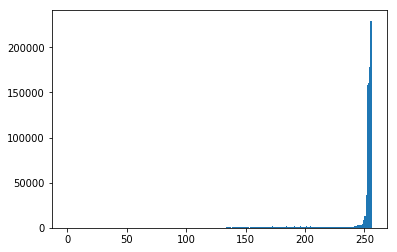

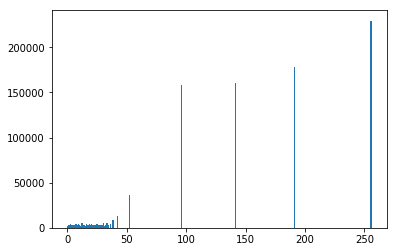

(<matplotlib.figure.Figure at 0x1a020208>,
 <matplotlib.image.AxesImage at 0x1d178828>)

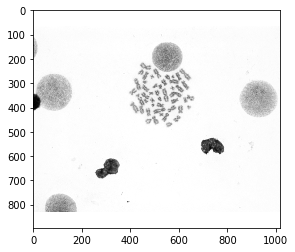

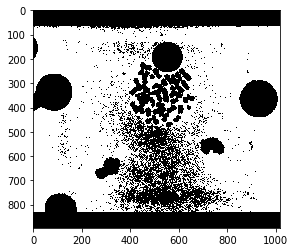

In [28]:
def show_histogram(image):
    plt.hist(image.ravel(),256,[0,256]), plt.show()
    
def histogram_equalization(image):
    equ = cv2.equalizeHist(image)
    return equ
    
img = cv2.imread(parent_dir + '/data/dapi_raw.BMP', 0)
min_intensity = np.amin(img)
max_intensity = np.amax(img)
print(min_intensity)
print(max_intensity)
normalized_img = (max_intensity - img) * 255 / (max_intensity - min_intensity)
show_histogram(img)
show_histogram(histogram_equalization(img))
plt.figure(), plt.imshow(img, cmap='gray')
plt.figure(), plt.imshow(normalized_img, cmap='gray')